# Bayesian inference

## Time to capture prey

### Load packages

In [1]:
using Distributions
using DataFrames
using Plots
using Turing
using StatsPlots
import CSV
default(dpi = 120, titlefontsize = 11)

### Read data

Simulated data corresponding to the time fur seals need to capture their first prey.

In [2]:
data = CSV.read("../data/simulated/time-to-capture.csv", DataFrame)
n = nrow(data)

10

### Bayesian inference with conjugate posterior

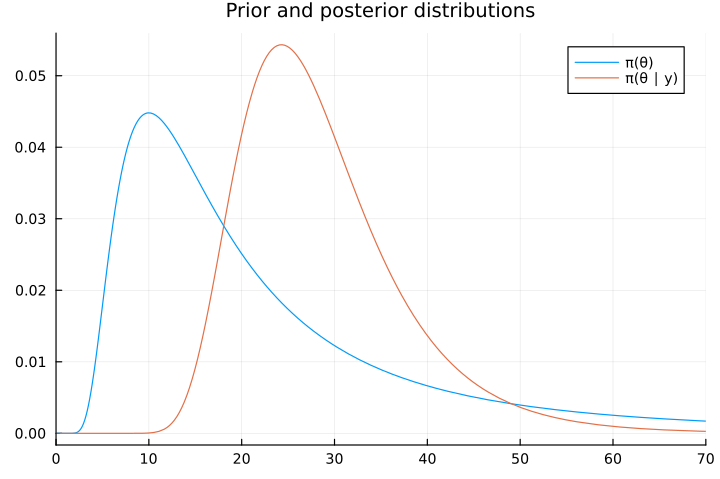

In [3]:
a, b = 2, 30 ## hyperparametros
prior = InverseGamma(a, b)
posterior = InverseGamma(n + a, b + sum(data.time))

plot(x -> pdf(prior, x), xlim = (0, 70), label = "π(θ)",
    title = "Prior and posterior distributions")
plot!(x -> pdf(posterior, x), label = "π(θ ∣ y)")

#### Point estimate

In [4]:
mean(posterior)

28.696733901999153

In [5]:
var(posterior)

82.35025366421475

#### Credible interval

In [6]:
α = 0.1
qq = quantile(posterior, [α/2, 1 - α/2])

2-element Vector{Float64}:
 17.33702187855346
 45.58844378370344

#### Comparison with a classical MLE estimator

In [7]:
est = Normal(mean(data.time), sqrt(var(data.time) / 10))

Normal{Float64}(μ=28.566407292199067, σ=11.207257206548583)

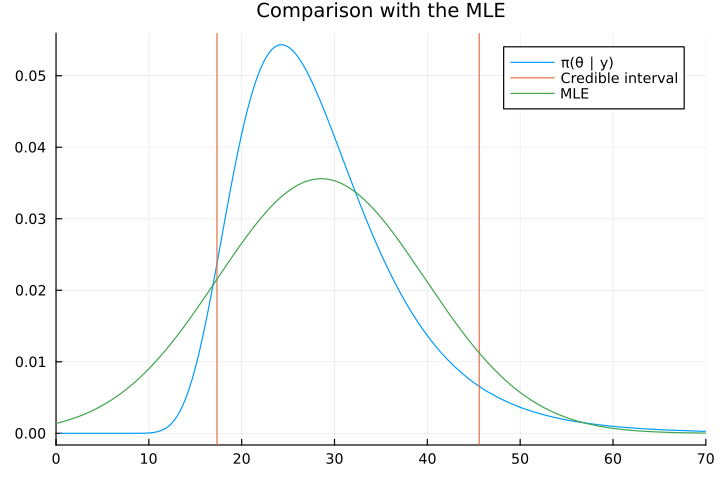

In [8]:
plot(x -> pdf(posterior, x), label = "π(θ ∣ y)", xlim = (0, 70),
    title = "Comparison with the MLE")
plot!(qq, st = :vline, label = "Credible interval")
plot!(x -> pdf(est, x), label = "MLE")

#### Excedance probability

In [9]:
plot(x -> pdf(posterior, x), label = "π(θ ∣ y)", xlim = (0, 70),
    title = "Excedance probability"
)
plot!([30], st = :vline, ls = :dash, label = "Threshold")
1 - cdf(posterior, 30)

0.363887865883776

#### A function of the parameter

Distribution of a more complex function $log(\theta)$.

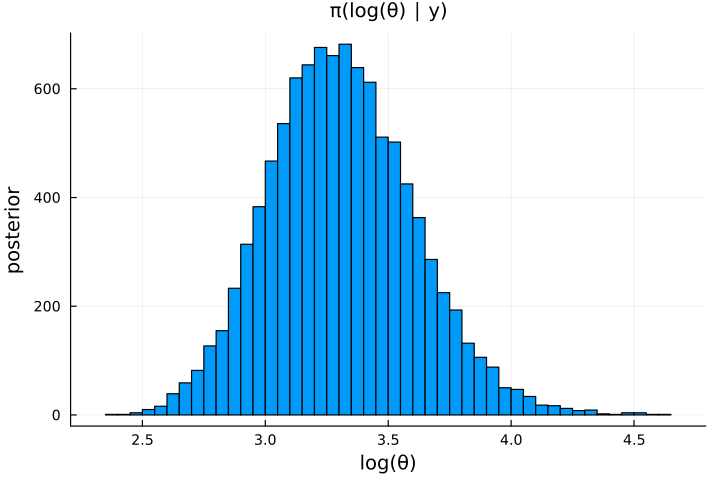

In [10]:
histogram(log.(rand(posterior, 10000)), normalise = true, title = "π(log(θ) ∣ y)",
    label = false, xlab = "log(θ)", ylab = "posterior")

mean of a more complex function

In [11]:
mean(log.(rand(posterior, 10000))) # adequate
log(mean(posterior)) # wrong

3.356783314965642

### Using the Turing package

Define the Bayesian model.

In [12]:
@model function bayes_exponential(y, n)
    # prior
    θ ~ InverseGamma(2, 30)

    # likelihood
    for i in 1:n
        y[i] ~ Exponential(θ)
    end
end

bayes_exponential (generic function with 2 methods)

Evaluate the model in the data.

In [13]:
m1 = bayes_exponential(data.time, 10)

DynamicPPL.Model{typeof(Main.var"##2132".bayes_exponential), (:y, :n), (), (), Tuple{Vector{Float64}, Int64}, Tuple{}, DynamicPPL.DefaultContext}(Main.var"##2132".bayes_exponential, (y = [20.78831313602355, 5.157479970876626, 49.445725075394265, 9.904663041485154, 0.07705144940575732, 80.41054648907986, 7.519265524213915, 99.26180880969429, 5.602735167658112, 7.496484258159109], n = 10), NamedTuple(), DynamicPPL.DefaultContext())

Sample from the posterior distribution using MCMC.

In [14]:
chain = Turing.sample(m1, NUTS(0.65), 5000)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
└   ϵ = 0.4
Sampling   0%|▎                                         |  ETA: 0:02:12
Sampling   1%|▍                                         |  ETA: 0:01:05
Sampling   2%|▋                                         |  ETA: 0:00:43
Sampling   2%|▉                                         |  ETA: 0:00:32
Sampling   2%|█                                         |  ETA: 0:00:26
Sampling   3%|█▎                                        |  ETA: 0:00:21
Sampling   4%|█▌                                        |  ETA: 0:00:18
Sampling   4%|█▋                                        |  ETA: 0:00:16
Sampling   4%|█▉                                        |  ETA: 0:00:14
Sampling   5%|██▏                                       |  ETA: 0:00:13
Sampling   6%|██▎                                       |  ETA: 0:00:11
Sampling   6%|██▌                                       |  ETA: 0:00:10
Sampling   6%|██▊       

Chains MCMC chain (5000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 0.97 seconds
Compute duration  = 0.97 seconds
parameters        = θ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           θ   28.7918    9.3929     0.1328    0.1808   2200.3006    0.9998    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%
      Symbol   Float64   Float64   Float64   Float64   Float64

           θ   16.1320   22.3649   27.0315   33.1020   51.1267


Visualise traceplot and density of the posterior.

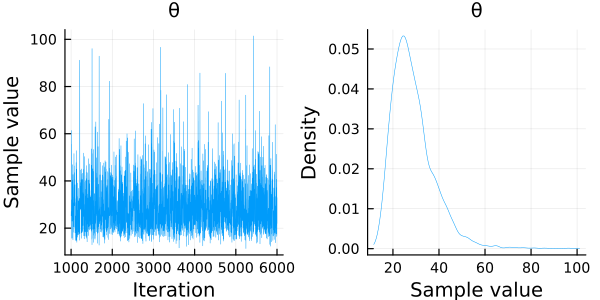

In [15]:
plot(chain, lw = 0.4, size = (500, 250))

Visualise prior and posterior densities.

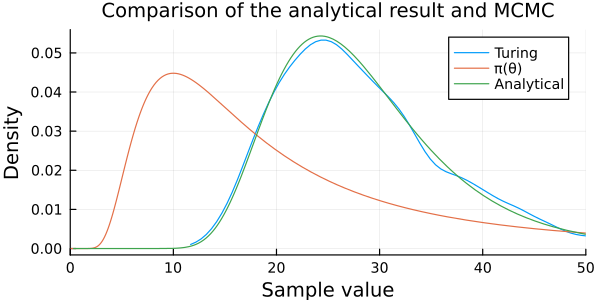

In [16]:
plot(chain, st = :density, legend = true, label = "Turing")
plot!(x -> pdf(prior, x), xlim = (0, 50), label = "π(θ)",
    title = "Comparison of the analytical result and MCMC")
plot!(x -> pdf(posterior, x), label = "Analytical")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*